<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Check-your-TensorFlow-version" data-toc-modified-id="Check-your-TensorFlow-version-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Check your TensorFlow version</a></span></li><li><span><a href="#Generate-training-data" data-toc-modified-id="Generate-training-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generate training data</a></span></li><li><span><a href="#Define-a-TF-model" data-toc-modified-id="Define-a-TF-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define a TF model</a></span></li><li><span><a href="#Create-an-instance-of-a-model-and-use-it" data-toc-modified-id="Create-an-instance-of-a-model-and-use-it-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create an instance of a model and use it</a></span></li><li><span><a href="#Define-a-loss" data-toc-modified-id="Define-a-loss-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Define a loss</a></span></li><li><span><a href="#Define-a-training-function" data-toc-modified-id="Define-a-training-function-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Define a training function</a></span></li><li><span><a href="#Training-of-the-model" data-toc-modified-id="Training-of-the-model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Training of the model</a></span></li><li><span><a href="#Comparison-of-found-model-parameters-and-ground-truth" data-toc-modified-id="Comparison-of-found-model-parameters-and-ground-truth-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Comparison of found model parameters and ground truth</a></span></li></ul></div>

The code here is inspired by the following blog post:
    
https://heartbeat.fritz.ai/linear-regression-using-tensorflow-2-0-1cd51e211e1f

# Check your TensorFlow version

In [45]:
import tensorflow as tf

In [46]:
print(tf.__version__)

2.0.0


# Generate training data

In [26]:
import numpy as np
nr_points = 120
np.random.normal(0,1, (nr_points))

array([-0.03842409, -0.69505521,  0.42452768,  0.16869375,  1.38167297,
       -1.44166421, -2.23776217,  1.50093793,  0.98713948,  0.25853488,
        2.07079389,  0.52522311,  1.3326148 ,  2.04279337,  0.2924868 ,
       -0.59890788, -0.86640303,  0.08647786, -0.53471635,  0.12714603,
        1.83481564,  1.20660427, -1.94163322,  0.2356258 , -0.86650638,
        0.55438532,  0.10418535,  0.58723093,  1.01862466, -0.95690419,
        1.97302373, -1.35607758,  0.22351871,  1.23078233, -1.0808954 ,
        0.63019211,  1.8422039 ,  0.21473947, -0.6650493 , -0.04183891,
       -1.21839694,  0.16733973,  0.12099721,  0.63147111, -0.8458698 ,
       -0.84637754, -0.4085107 , -0.08271611, -1.7492377 ,  1.78395347,
        1.07422342,  1.1572923 ,  0.9594014 ,  1.17967999, -0.54586751,
       -2.43705792, -2.08127122,  1.17433209,  0.69463636,  0.63744986,
        0.91833562, -0.06706729, -1.78991664,  0.75421586, -0.37191225,
        0.30369969,  0.75550061,  2.26399891,  0.01285473,  1.06

In [87]:
TRUE_SLOPE = 2.0
TRUE_INTERCEPT = 0.9

x = np.linspace(0, 10, nr_points)
y = TRUE_SLOPE * x + TRUE_INTERCEPT + np.random.normal(0,1, (nr_points)) * 2.0

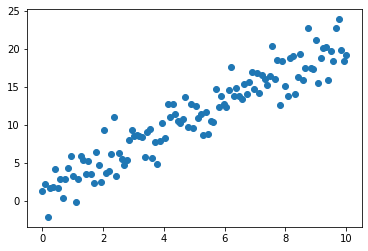

In [88]:
import matplotlib.pyplot as plt

plt.scatter(x,y)
plt.show()

# Define a TF model

In [29]:
class LinearModel:
    
    def __call__(self, x):
        return self.Weight * x + self.Bias
    
    def __init__(self):
        self.Weight = tf.Variable(42.0)
        self.Bias = tf.Variable(1.234)

What is the magic method `__call__()` good for?

In [39]:
class test:
    
    def __call__(self,x):
        return x**3

In [40]:
t = test()

In [41]:
t(2)

8

# Create an instance of a model and use it

... without having learned the weights!

Training of the model parameters will be shown later!

In [72]:
my_model = LinearModel()

In [73]:
preds = my_model(x)

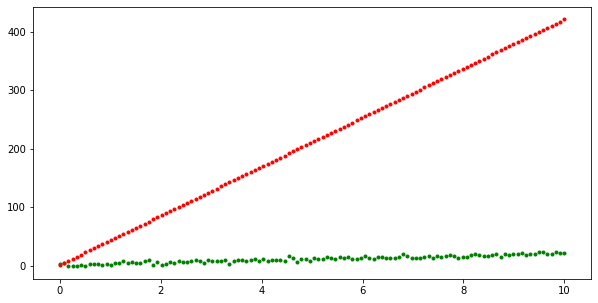

In [74]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
plt.scatter(x,y,     color="green", marker=".", label="teacher values")
plt.scatter(x,preds, color="red",   marker=".", label="predictions")
plt.show()

# Define a loss

In [75]:
def loss(y, pred):
    """
    compute the loss of the model
    
    here it is defined as the mean
    squared error (MSE)
    """
    return tf.reduce_mean(tf.square(y - pred))

# Define a training function

For TensorFlow to be able to automatically compute the gradient of a loss function with respect to the model parameters (here: `linear_model.Weight` and `linear_model.Bias`), we need to know which tensor ops were computed.

These operations are recorded on a gradient tape using a `tf.GradientTape()` context manager:

In [78]:
def train(linear_model, x, y, lr=0.12):
    """
    Train the model using backpropagation
    
    Given a model linear_model and an input
    x and a desired output y, we
    1. do one forward step
    2. retrieve the gradient of the loss function
       with respect to the model parameters
    3. do a step in to the negative direction
       of the gradient (multiplied by the
       learning rate lr), i.e., do gradient descent
    """
    
    # 1. 
    # Compute the loss
    # This indirectly induces the computation
    # the output of the model by
    # linear_model(x)
    # which is implemented by the __call__()
    # function
    with tf.GradientTape() as t:
        current_loss = loss(y, linear_model(x))

    # 2.
    # Automatically compute the gradient
    # of the loss with respect to the
    # two model parameters
    dloss_dweight, dloss_dbias = \
        t.gradient(current_loss, [linear_model.Weight, linear_model.Bias])
    
    # 3.
    # Do gradient descent
    linear_model.Weight.assign_sub(lr * dloss_dweight)
    linear_model.Bias.assign_sub  (lr * dloss_dbias)

# Training of the model

In [109]:
linear_model = LinearModel()
Weights, Biases, Losses = [], [], []
epochs = 500
for epoch_count in range(epochs):
    Weights.append(linear_model.Weight.numpy()) 
    Biases.append(linear_model.Bias.numpy())
    real_loss = loss(y, linear_model(x))
    Losses.append(real_loss)
    
    train(linear_model, x, y, lr=0.01)
    if epoch_count % 10 == 0:
        print(f"Epoch count {epoch_count}: Loss value: {real_loss.numpy()}")

Epoch count 0: Loss value: 53660.71484375
Epoch count 10: Loss value: 12.17579174041748
Epoch count 20: Loss value: 11.382485389709473
Epoch count 30: Loss value: 10.664152145385742
Epoch count 40: Loss value: 10.013710975646973
Epoch count 50: Loss value: 9.424739837646484
Epoch count 60: Loss value: 8.89142894744873
Epoch count 70: Loss value: 8.408519744873047
Epoch count 80: Loss value: 7.971249580383301
Epoch count 90: Loss value: 7.575303554534912
Epoch count 100: Loss value: 7.216778755187988
Epoch count 110: Loss value: 6.892134189605713
Epoch count 120: Loss value: 6.598172187805176
Epoch count 130: Loss value: 6.331991672515869
Epoch count 140: Loss value: 6.090966701507568
Epoch count 150: Loss value: 5.8727192878723145
Epoch count 160: Loss value: 5.675097465515137
Epoch count 170: Loss value: 5.496153354644775
Epoch count 180: Loss value: 5.33411979675293
Epoch count 190: Loss value: 5.1874003410339355
Epoch count 200: Loss value: 5.05454683303833
Epoch count 210: Loss val

# Comparison of found model parameters and ground truth

In [110]:
TRUE_SLOPE

2.0

In [111]:
TRUE_INTERCEPT

0.9

In [112]:
Weights[-1]

2.0155268

In [113]:
Biases[-1]

0.8852002

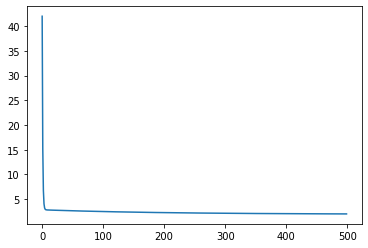

In [114]:
plt.plot(Weights)
plt.show()

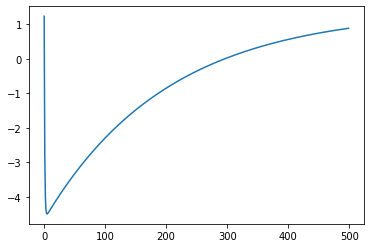

In [115]:
plt.plot(Biases)
plt.show()